# Bellman's Grid World

This is the general playground to test the Double Conditional Maximum Entropy Inverse Learning (**DECIMEIL**) Algorithm. The premise is a `10 x 10` grid world with various routes starting from different origins `s` and ending at different destinations `g`. 

Each link $i$ has a routing cost, *intrinsic* to the link itself.
$$ c_\theta (i) = f(\text{distance, wind, sector load, airspace charge, convections, (airline preference, source, goal)}) $$

Other consideration: path-overlapping correction term for the logit $\rightarrow$ will be dealt with later when we gradually expand the expressiveness of the cost function.

The goal of **DECIMEIL** is to:
- Learn a discrete choice model that explains the route choice for each flight.
- Adaptable to large scale learning.
- Expandable to neural network based cost approximations.

# Create the grid world and demonstration routes

In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx 
from matplotlib import pyplot as plt 
import numpy as np

Created 4950 edges out of 300 possible edges
NOTICE: The nodes are strings, not integers.


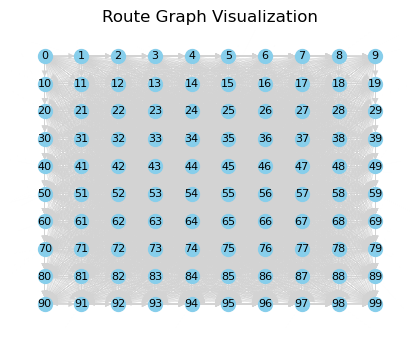

In [2]:
# Create a graph consisting of 100 nodes
# Create a graph with 100 nodes in a 10x10 grid
G = nx.DiGraph()

# Add nodes with attributes
for i in range(100):
    row = i // 10  # Integer division to get row (0-4)
    col = i % 10   # Modulo to get column (0-4)
    G.add_node(str(i), label=i, row=row, col=col, lat=row*0.1, lon=col*0.1)

# Add all possible edges between the 100 nodes (100C2 edges)
for i in range(100):
    for j in range(i+1, 100):  # Start from i+1 to avoid duplicates and self-loops
        # Calculate distance between nodes based on their grid positions
        node_i_row, node_i_col = G.nodes[str(i)]['row'], G.nodes[str(i)]['col']
        node_j_row, node_j_col = G.nodes[str(j)]['row'], G.nodes[str(j)]['col']
        
        # Euclidean distance as edge weight
        distance = np.sqrt((node_i_row - node_j_row)**2 + (node_i_col - node_j_col)**2)
        
        # Add edge with distance as weight
        G.add_edge(str(i), str(j), weight = distance, distance = distance, preference_score = 0.0)

# Print the number of edges to verify
print(f"Created {G.number_of_edges()} edges out of {25*24//2} possible edges")
print(f'NOTICE: The nodes are strings, not integers.')

# Visualize the graph
plt.figure(figsize=(4, 3))

# Get node positions from row and col attributes
pos = {node: (G.nodes[node]['col'], -G.nodes[node]['row']) for node in G.nodes()}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, font_size=8, edge_color='lightgray', width=0.25)

# Draw edge weights (distances)
# edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Route Graph Visualization")
plt.axis('off')  # Turn off axis
plt.show()

In [3]:
import math
import random

def generate_routes(G, node_ori, node_dest):
    """
    Generate 5 different routes from origin to destination node in the graph.
    
    Args:
        G (networkx.Graph): The graph to search
        node_ori (int): Origin node ID
        node_dest (int): Destination node ID
        
    Returns:
        list: List of 5 different paths, where each path is a list of node IDs
    """
    routes = []
    
    # 1. Shortest path (using Dijkstra's algorithm)
    try:
        shortest_path = nx.shortest_path(G, source=node_ori, target=node_dest, weight='weight')
        routes.append(shortest_path)
    except nx.NetworkXNoPath:
        print(f"No path exists between nodes {node_ori} and {node_dest}")
        return []
    
    # 2. Second shortest path using edge removal technique
    temp_graph = G.copy()
    for i in range(len(shortest_path)-1):
        # Temporarily remove each edge in the shortest path and find alternative
        u, v = shortest_path[i], shortest_path[i+1]
        temp_graph.remove_edge(u, v)
        try:
            alt_path = nx.shortest_path(temp_graph, source=node_ori, target=node_dest, weight='weight')
            if alt_path not in routes:
                routes.append(alt_path)
                break
        except nx.NetworkXNoPath:
            pass
        # Restore the edge for next iteration
        temp_graph.add_edge(u, v, weight=G[u][v]['weight'])
    
    # # 3. Multiple paths with random weights (to encourage diversity)
    # for attempt in range(10):  # Try to generate 3 different paths with random weights
    #     rand_graph = G.copy()
    #     for u, v in rand_graph.edges():
    #         # Add random factor to weights with different randomization each time
    #         rand_factor = 0.3 + random.random() * 1.4  # Wider range for more diversity
    #         rand_graph[u][v]['weight'] = G[u][v]['weight'] * rand_factor
        
    #     try:
    #         rand_path = nx.shortest_path(rand_graph, source=node_ori, target=node_dest, weight='weight')
    #         if rand_path not in routes:
    #             routes.append(rand_path)
    #     except nx.NetworkXNoPath:
    #         continue
    
    # 4. Multiple paths with more nodes (longer but potentially more interesting)
    for attempt in range(10):  # Try different variations of the longer path approach
        long_graph = G.copy()
        for u, v in long_graph.edges():
            # Vary the transformation to get different long paths
            if attempt == 0:
                # Use reciprocal of weight instead of negative log
                long_graph[u][v]['inv_weight'] = 1.0 / (G[u][v]['weight'] + 0.001)  # Add small constant to avoid division by zero
            elif attempt == 1:
                # Reciprocal with random factor
                long_graph[u][v]['inv_weight'] = 1.0 / ((G[u][v]['weight'] * (0.7 + random.random() * 0.6)) + 0.001)
            else:
                # More extreme transformation to prefer even more hops
                long_graph[u][v]['inv_weight'] = 1.0 / ((G[u][v]['weight'] ** 2) + 0.001)
        
        try:
            long_path = nx.shortest_path(long_graph, source=node_ori, target=node_dest, weight='inv_weight')
            if long_path not in routes:
                routes.append(long_path)
        except nx.NetworkXNoPath:
            continue
    
    # 5. A* path with custom heuristic
    def heuristic(u, v):
        # Manhattan distance on the grid
        u_row, u_col = G.nodes[u]['row'], G.nodes[u]['col']
        v_row, v_col = G.nodes[v]['row'], G.nodes[v]['col']
        return abs(u_row - v_row) + abs(u_col - v_col)
    
    a_star_path = nx.astar_path(G, source=node_ori, target=node_dest, 
                                heuristic=heuristic, weight='weight')
    if a_star_path not in routes:
        routes.append(a_star_path)
    
    # If we still need more routes, generate some with random walks
    while len(routes) < 20:
        current = node_ori
        path = [current]
        visited = set([current])
        
        while current != node_dest:
            neighbors = list(G.neighbors(current))
            # Filter out already visited nodes if possible
            unvisited = [n for n in neighbors if n not in visited]
            if not unvisited and not neighbors:
                # Dead end with no way to destination
                break
            if not unvisited:
                # If all neighbors visited, allow revisiting
                unvisited = neighbors
            
            # Choose neighbor that's closer to destination with some randomness
            weights = []
            for n in unvisited:
                # Prefer nodes closer to destination
                n_row, n_col = G.nodes[n]['row'], G.nodes[n]['col']
                dest_row, dest_col = G.nodes[node_dest]['row'], G.nodes[node_dest]['col']
                dist_to_dest = math.sqrt((n_row - dest_row)**2 + (n_col - dest_col)**2)
                # Lower distance gets higher weight
                weights.append(1.0 / (dist_to_dest + 0.1))
            
            # Normalize weights
            total = sum(weights)
            weights = [w/total for w in weights]
            
            next_node = random.choices(unvisited, weights=weights)[0]
            path.append(next_node)
            visited.add(next_node)
            current = next_node
            
            # Prevent infinite loops
            if len(path) > 3 * len(G):
                break
        
        if current == node_dest and path not in routes:
            routes.append(path)
    
    # Ensure we return exactly 10 routes (or fewer if impossible)
    return routes[:20]

In [4]:
def plot_routes(G, routes, node_size=200, route_colors=None, line_width=2, alpha=0.7, probabilities=None):
    """
    Plot multiple routes on the graph, each in its own subplot.
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph containing the nodes and edges
    routes : list of lists
        List of routes, where each route is a list of node IDs
    figsize : tuple, optional
        Figure size (width, height) in inches
    node_size : int, optional
        Size of the nodes in the plot
    route_colors : list, optional
        List of colors for each route. If None, colors will be generated automatically
    line_width : int, optional
        Width of the route lines
    alpha : float, optional
        Transparency of the route lines
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import networkx as nx
    import math
    
    # Calculate grid dimensions
    n_routes = len(routes)
    n_rows, n_cols = 5, 5

    # Automatically determine figure size based on number of routes
    if n_routes <= 4:
        n_rows, n_cols = 2, 2
        figsize = (8, 6)
    elif n_routes <= 9:
        n_rows, n_cols = 3, 3
        figsize = (12, 10)
    elif n_routes <= 16:
        n_rows, n_cols = 4, 4
        figsize = (16, 13)
    else:
        n_rows, n_cols = 5, 5
        figsize = (20, 16)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Get node positions from the graph
    pos = {node: (G.nodes[node]['col'], -G.nodes[node]['row']) for node in G.nodes()}
    
    # Generate colors for routes if not provided
    if route_colors is None:
        # Use a colormap to generate distinct colors
        cmap = plt.cm.rainbow
        route_colors = [cmap(i/n_routes) for i in range(n_routes)]
    
    # Plot each route in its own subplot
    for i, route in enumerate(routes):
        if i >= n_rows * n_cols:
            break  # Don't exceed available subplots
            
        ax = axes[i]
        
        # Draw the graph structure (all nodes and edges)
        nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=node_size/2, ax=ax)
        # nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=0.5, alpha=0.5, ax=ax)
        
        # Draw the route edges
        route_edges = [(route[j], route[j+1]) for j in range(len(route)-1)]
        color = route_colors[i % len(route_colors)]
        
        # Draw the route
        nx.draw_networkx_edges(G, pos, edgelist=route_edges, 
                              edge_color=[color], width=line_width, alpha=alpha, ax=ax)
        
        # Highlight start and end nodes
        nx.draw_networkx_nodes(G, pos, nodelist=[route[0]], 
                              node_color='green', node_size=node_size, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[route[-1]], 
                              node_color='red', node_size=node_size, ax=ax)
        
        # Add node labels for start and end nodes
        labels = {node: str(node) for node in [route[0], route[-1]]}
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax)
        if probabilities is not None:
            ax.set_title(f"Route {i}: {route[0]} → {route[-1]}\nProb: {probabilities[i]:.2f}")
        else:
            ax.set_title(f"Route {i}: {route[0]} → {route[-1]}")
        ax.axis('off')
    
    # Hide any unused subplots
    for i in range(n_routes, n_rows * n_cols):
        axes[i].axis('off')
    
    plt.suptitle(f"Graph with {n_routes} routes", fontsize=16)
    plt.tight_layout()
    return fig


## Route Cluster 1: 0 → 24

In [5]:
# Set random seed for reproducibility
import random
random.seed(69420)

routes_0_24 = generate_routes(G, '0', '24')


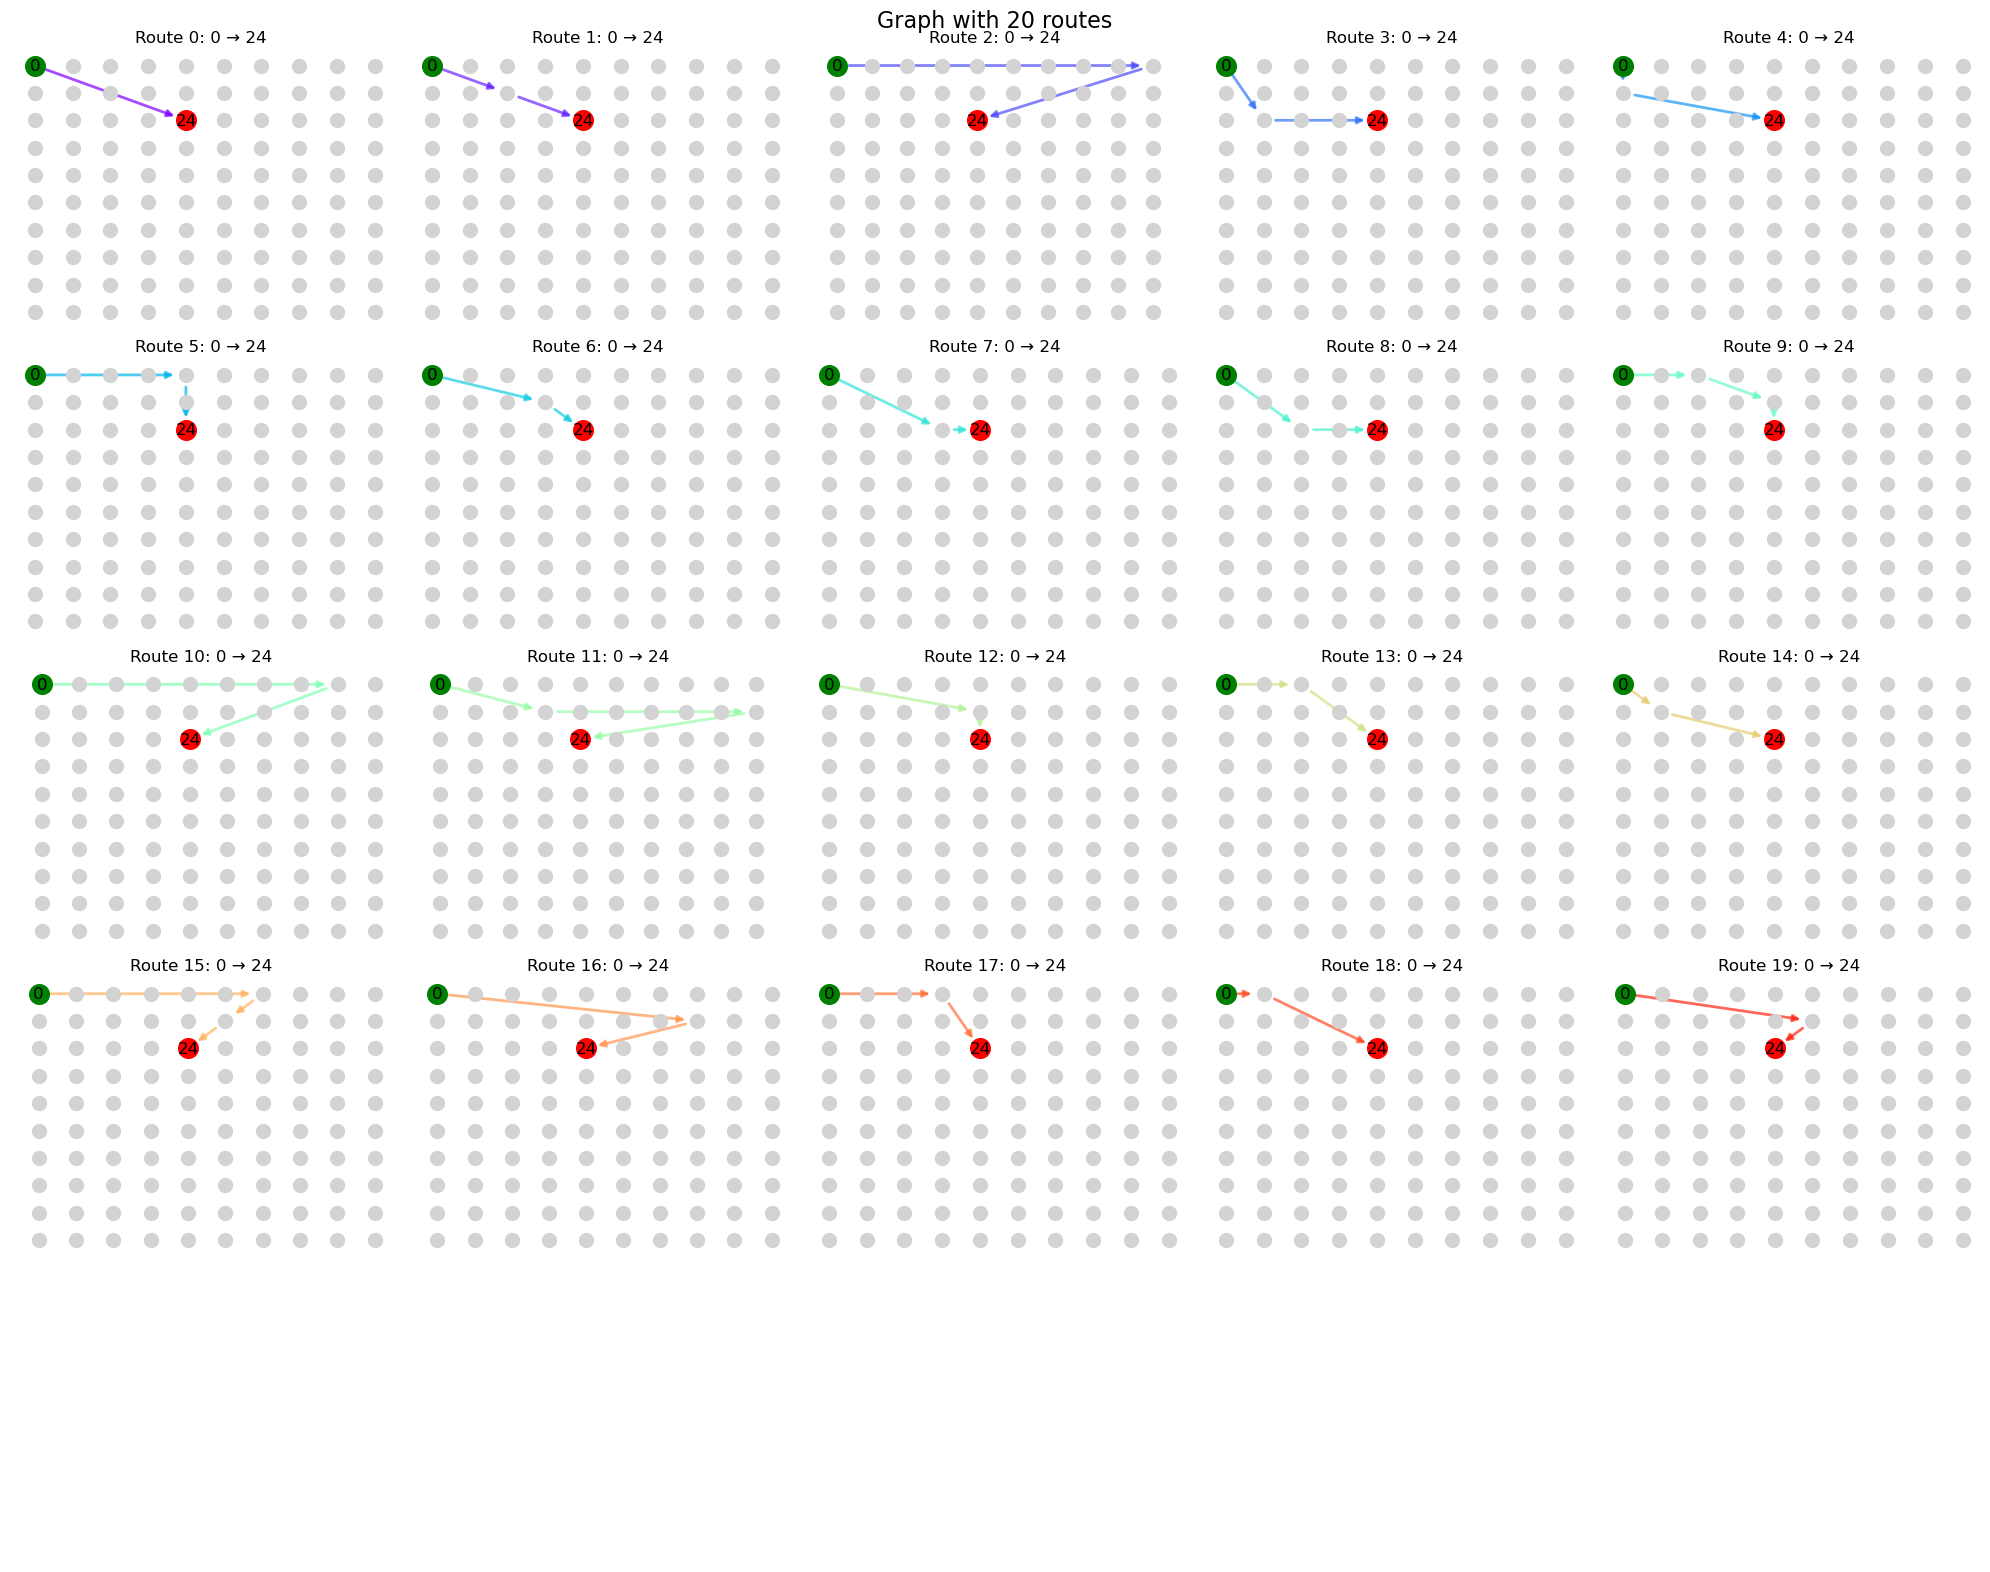

In [6]:
plot_routes(G, routes_0_24)
plt.show()


In [7]:
routes_0_24_final = [routes_0_24[x] for x in [0, 1, 6, 8, 9, 10, 15, 18]]
# Create a random probability distribution for the routes
probabilities = np.random.rand(len(routes_0_24_final))

# Normalize the probabilities to sum to 1
routes_0_24_final_prob = [p / sum(probabilities) for p in probabilities]

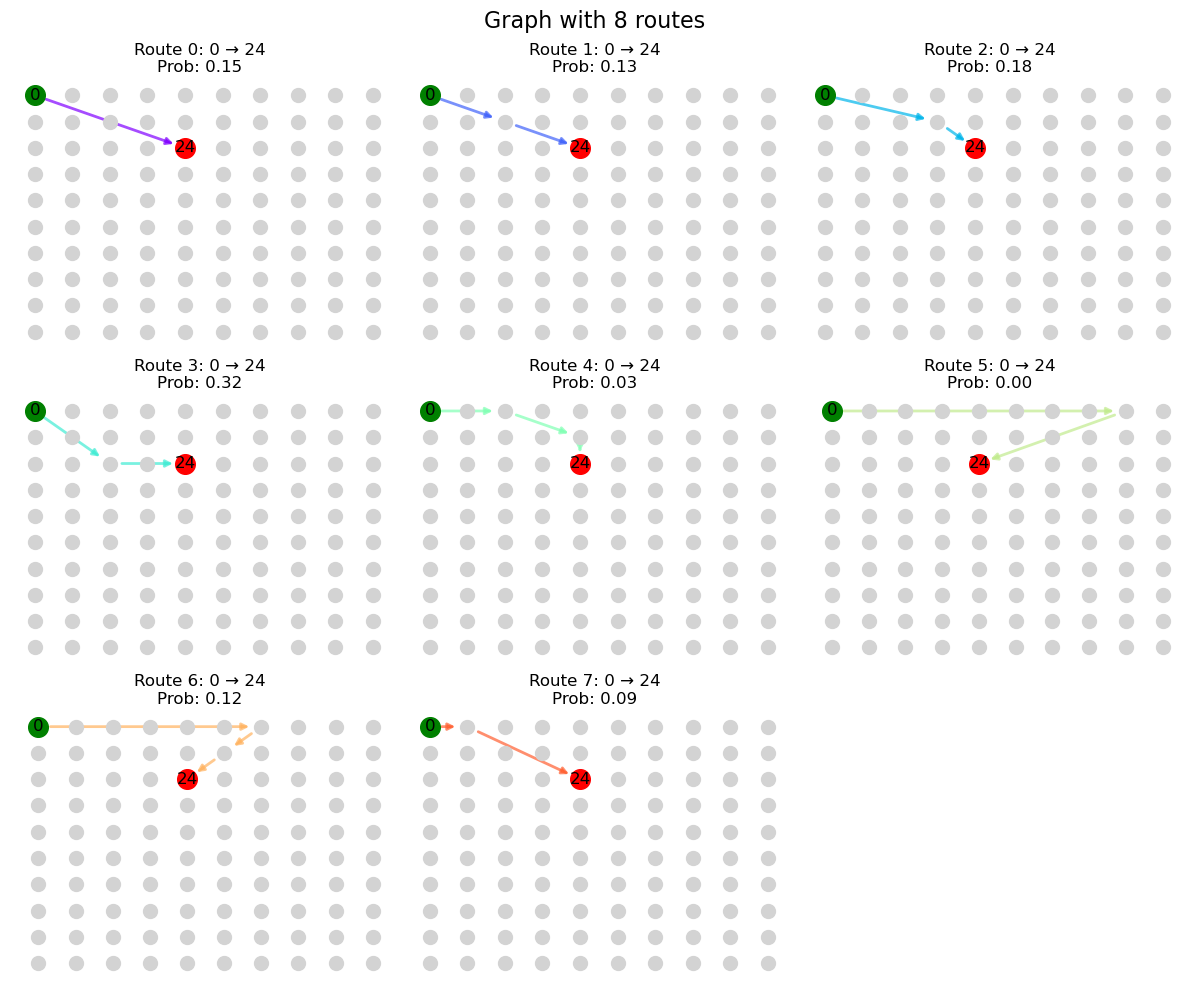

In [8]:
plot_routes(G, routes_0_24_final, probabilities=routes_0_24_final_prob)
plt.show()

# Cost, Adjacency Matrix Computation

In [9]:
from bellman_ford_sparse1100 import compute_edge_costs_dict

costs = compute_edge_costs_dict(G, alpha_pref = 1.0)

In [10]:
from bellman_ford_sparse1100 import graph_to_sparse_matrices
A, C, node_mapping = graph_to_sparse_matrices(G, costs) # note the graph is directional. There are no "going-back" links.
# Check sparsity pattern match
from bellman_ford_sparse1100 import check_sparsity_pattern_match
check_sparsity_pattern_match(A, C)

True

# Value Iterations

## Forward and Backward Value Functions

In [11]:
from bellman_ford_sparse1100 import bellman_fw, bellman_bw
import time 
start_time = time.time()
V_fw = bellman_fw(A, C, 0, max_iter=1000, tol=1e-6, epsilon=1e-10)
V_fw_time = time.time() - start_time
start_time = time.time()
V_bw = bellman_bw(A, C, 24, max_iter=1000, tol=1e-6, epsilon=1e-10)
V_bw_time = time.time() - start_time
print(f'Forward VI time: {V_fw_time:.4f} seconds')
print(f'Backward VI time: {V_bw_time:.4f} seconds')

Forward VI time: 0.0085 seconds
Backward VI time: 0.0017 seconds


## Bellman Forward Validation

We also compute the value function in a more traditional way in order to verify the vectorization trick we used in the `sparse1100` library.

In [12]:
def bellman_fw_verification(graph: nx.DiGraph, costs: dict, 
                           max_iterations: int = 1000, 
                           tolerance: float = 1e-5) -> dict:
    """
    Computes the value function for all nodes using the logsumexp formula:
    V(i) = -log(∑_{k ∈ pred(i)} exp(-weight_of_edge_k - cost(k, i)))
    
    This is a verification function that computes values in a single pass for each node
    based on its predecessors' values.
    
    Parameters:
    -----------
    graph : nx.DiGraph
        The directed graph representing the route network
    
    costs : dict
        Dictionary mapping edge tuples (u, v) to their costs
    
    max_iterations : int, optional (default=1000)
        Maximum number of iterations to perform
    
    tolerance : float, optional (default=1e-5)
        Convergence tolerance
        
    Returns:
    --------
    dict
        Dictionary mapping nodes to their computed value functions
    """
    from scipy.special import logsumexp
    import numpy as np
    
    # Get all nodes in the graph
    nodes = list(graph.nodes())
    
    # Initialize values to infinity
    V = {node: np.inf for node in nodes}
    
    # Find sources (nodes with no incoming edges)
    sources = [node for node in nodes if len(list(graph.predecessors(node))) == 0]
    
    # Initialize source nodes with value 0
    for source in sources:
        V[source] = 0.0
    
    # If no sources found, pick a node and make it the source
    if not sources and nodes:
        V[nodes[0]] = 0.0
    
    # Iterate until convergence or max iterations
    for iteration in range(max_iterations):
        V_old = V.copy()
        max_delta = 0.0
        
        for node in nodes:
            # Skip source nodes
            if node in sources:
                continue
                
            predecessors = list(graph.predecessors(node))
            if not predecessors:
                continue
                
            # Calculate terms for the logsumexp
            terms = []
            for pred in predecessors:
                edge = (pred, node)
                if edge in costs and np.isfinite(V_old[pred]):
                    # Use the formula V(i) = -log(∑_{k ∈ pred(i)} exp(-weight_of_edge_k - cost(k, i)))
                    terms.append(-costs[edge] - V_old[pred])
            
            # Compute new value with logsumexp
            if not terms:
                new_value = np.inf
            else:
                new_value = -logsumexp(terms)
            
            # Update value and track change
            delta = abs(new_value - V[node])
            max_delta = max(max_delta, delta)
            V[node] = new_value
        
        # Check for convergence
        if max_delta < tolerance:
            # print(f"Bellman-Ford verification converged in {iteration + 1} iterations.")
            return V
    
    # print(f"Warning: Bellman-Ford verification did not converge within {max_iterations} iterations. Max delta: {max_delta}")
    return V

In [13]:
time_start = time.time()
V_fw_test = bellman_fw_verification(G, costs)
time_end = time.time()
print(f'Verification time: {time_end - time_start:.4f} seconds')

Verification time: 0.1823 seconds


In [14]:
V_fw_test_matrix = np.zeros_like(V_fw)
for key, val in V_fw_test.items():
    V_fw_test_matrix[int(key)] = val 

In [15]:
if np.max(np.abs(V_fw - V_fw_test_matrix)) < 1e-3:
    print('\033[92mTwo VI methods arrive at the same result.\nTest passed. ✅\033[0m')
else:
    print('\033[91mTwo VI methods DID NOT arrive at the same result. Something is wrong!\033[0m')

Two VI methods arrive at the same result.
Test passed. ✅


## Bellman Backward Validation

In [16]:
import networkx as nx
from scipy.special import logsumexp
import numpy as np

def bellman_backward_verification(graph: nx.DiGraph, costs: dict, target: any,
                               max_iterations: int = 1000,
                               tolerance: float = 1e-5) -> dict:
    """
    Computes the cost-to-go value function for all nodes using the logsumexp formula:
    V(j) = -log(∑_{i ∈ succ(j)} exp(-cost(j, i) - V(i)))

    This function computes values iteratively starting from the target node
    and propagating backwards.

    Parameters:
    -----------
    graph : nx.DiGraph
        The directed graph representing the transitions. Nodes are keys.
    costs : dict
        Dictionary mapping edge tuples (u, v) to their costs cost(u, v).
    target : any
        The target/goal node, must be a key in the graph nodes.
    max_iterations : int, optional (default=1000)
        Maximum number of iterations to perform.
    tolerance : float, optional (default=1e-5)
        Convergence tolerance.

    Returns:
    --------
    dict
        Dictionary mapping nodes to their computed cost-to-go value functions.
        Nodes that cannot reach the target will have a value of infinity.

    Raises:
    -------
    ValueError
        If the target node is not found in the graph.
    """
    nodes = list(graph.nodes())

    if target not in nodes:
        raise ValueError(f"Target node {target} not found in the graph.")

    # Initialize values to infinity
    V = {node: np.inf for node in nodes}

    # Initialize target node value to 0
    V[target] = 0.0

    # Iterate until convergence or max iterations
    for iteration in range(max_iterations):
        V_old = V.copy()
        max_delta = 0.0

        # Compute new values for all nodes based on V_old
        V_new = {node: np.inf for node in nodes} # Initialize next iteration's values
        V_new[target] = 0.0 # Target value remains 0

        for node in nodes:
            # Skip target node, its value is fixed at 0
            if node == target:
                continue

            successors = list(graph.successors(node))

            # Calculate terms for the logsumexp based on V_old of successors
            terms = []
            for succ in successors:
                edge = (node, succ)
                # Include term if edge exists and successor has finite cost-to-go in V_old
                if edge in costs and np.isfinite(V_old[succ]):
                    # Argument for logsumexp is [-cost(j, i) - V_old(i)]
                    terms.append(-costs[edge] - V_old[succ])

            # Compute new value with logsumexp
            if not terms:
                # If no successors lead to a finite cost path to the target, value remains infinite
                current_new_value = np.inf
            else:
                # V(j) = -log(sum(exp(term_i)))
                current_new_value = -logsumexp(terms)

            V_new[node] = current_new_value

            # Calculate the change compared to the previous iteration's value V_old[node]
            delta = np.inf # Default to infinite change
            if np.isinf(V_old[node]) and np.isinf(current_new_value):
                 delta = 0.0 # No change if both are infinite
            elif not (np.isinf(V_old[node]) or np.isinf(current_new_value)):
                 # Calculate finite change only if both old and new values are finite
                 delta = abs(current_new_value - V_old[node])

            # Track the maximum *finite* change across all nodes for convergence check
            if np.isfinite(delta):
                 max_delta = max(max_delta, delta)

        # Update V for the next iteration
        V = V_new

        # Check for convergence
        if max_delta < tolerance and iteration > 50: # important: we iterate a little longer to ensure convergence
            print(f"Backward Bellman (logsumexp) converged in {iteration + 1} iterations.")
            return V

    # print(f"Warning: Backward Bellman (logsumexp) did not converge within {max_iterations} iterations. Max delta: {max_delta}")
    return V


In [17]:
time_start = time.time()
V_bw_test = bellman_backward_verification(G, costs, '24')
time_end = time.time()
print(f'Verification time: {time_end - time_start:.4f} seconds')

Backward Bellman (logsumexp) converged in 52 iterations.
Verification time: 0.1552 seconds


In [18]:
V_bw_test_matrix = np.zeros_like(V_bw)
for key, val in V_bw_test.items():
    V_bw_test_matrix[int(key)] = val 
if np.max(np.abs(V_bw[np.isfinite(V_bw) & np.isfinite(V_bw_test_matrix)] - V_bw_test_matrix[np.isfinite(V_bw) & np.isfinite(V_bw_test_matrix)])) < 1e-3:
    print('\033[92mTwo VI methods arrive at the same result.\nTest passed. ✅\033[0m')
else:
    print('\033[91mTwo VI methods DID NOT arrive at the same result. Something is wrong!\033[0m')

Two VI methods arrive at the same result.
Test passed. ✅


**<font color="green">All the tests appear to pass: the logsumexp vectorization trick worked marvelously, reducing computational speed by 10x.</font>**

# Double Conditioned Value Function

Value Functions (Lower is Better)


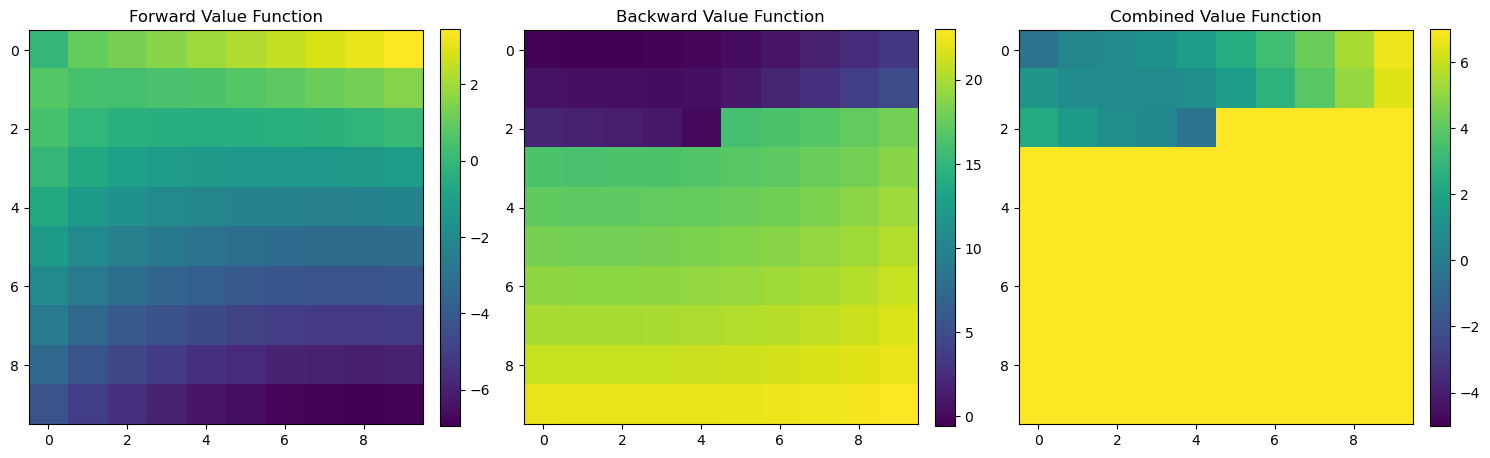

In [19]:
print('Value Functions (Lower is Better)')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
im1 = plt.imshow(V_fw.reshape(10, 10), cmap='viridis')
plt.title('Forward Value Function')
plt.colorbar(im1, fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
im2 = plt.imshow(V_bw.reshape(10, 10), cmap='viridis')
plt.title('Backward Value Function')
plt.colorbar(im2, fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
U = V_fw + V_bw
im3 = plt.imshow(U.reshape(10, 10), cmap='viridis', vmin=-5, vmax=7)
plt.title('Combined Value Function')
plt.colorbar(im3, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


Note that $V_{bw}(0) = -0.44$ is quite small (negative or positive is not important), while $V_{bw}(23) = 1.0$ is much larger. Two remarks about the backward value function:

- $V_{bw} \propto c$: the higher the cost is, the higher the value function is.
- $V_{bw} \propto \frac{1}{|\xi_{i\rightarrow g}|}$: the more paths from the node to the goal, the lower the value function is.

In this light, $V_{bw}(23)$ is just the cost of the edge from `23` to `24`, because it is the only connection. On the other hand, node `0` has lots of paths to `24` hence its value is lower.

**<font color='green'>So, this backward value function checks out.</font>**

# Edge Transition Probabilities

In [20]:
from bellman_ford_sparse1100 import compute_expected_traversals, compute_edge_transition_probabilities  
Pe_csr = compute_edge_transition_probabilities(A, C, V_fw, V_bw)
Pe = Pe_csr.toarray()

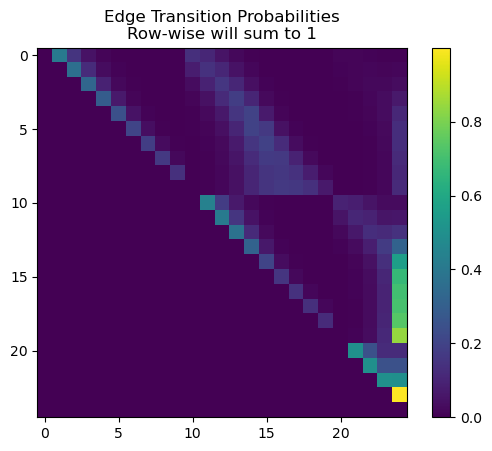

In [21]:
plt.imshow(Pe[0:25, 0:25])
plt.title('Edge Transition Probabilities\nRow-wise will sum to 1')
plt.colorbar()
plt.show()


# Edge Traversals

In [22]:
from bellman_ford_sparse1110 import compute_edge_traversal_likelihoods
edge_traversals = compute_edge_traversal_likelihoods(A, C, V_fw, V_bw, 0)

**NOTICE**: `edge_traversals` is the expected number of traversals, that is:
$$ L(i, j) = P(i, j) = \frac{exp(-V_f(i) - c_{ij} - V_b(j))}{Z} $$
where
$$ Z = -V_b(s) = \sum_{\xi_{s \rightarrow g}} exp(-c(\xi)) $$

But the `edge_transition_probabilities` are $p(i | j)$ such that:
$$ \sum_{j \in succ(i)} p(i | j) = 1 $$
The probability sum holds for *every* source node of a link.

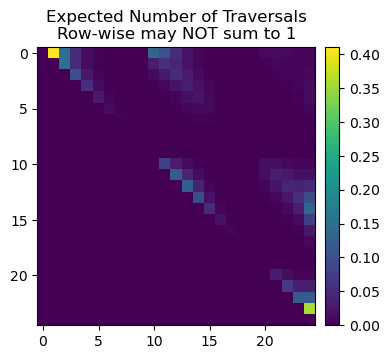

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax2 = plt.subplots(figsize=(4, 4))

# Second subplot (Edge Traversals)
im2 = ax2.imshow(edge_traversals.toarray().reshape((100, 100))[:25, :25])
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax2)
ax2.set_title('Expected Number of Traversals\nRow-wise may NOT sum to 1')

plt.tight_layout()
plt.show()


There probabilities always sum to 1 for each source node!


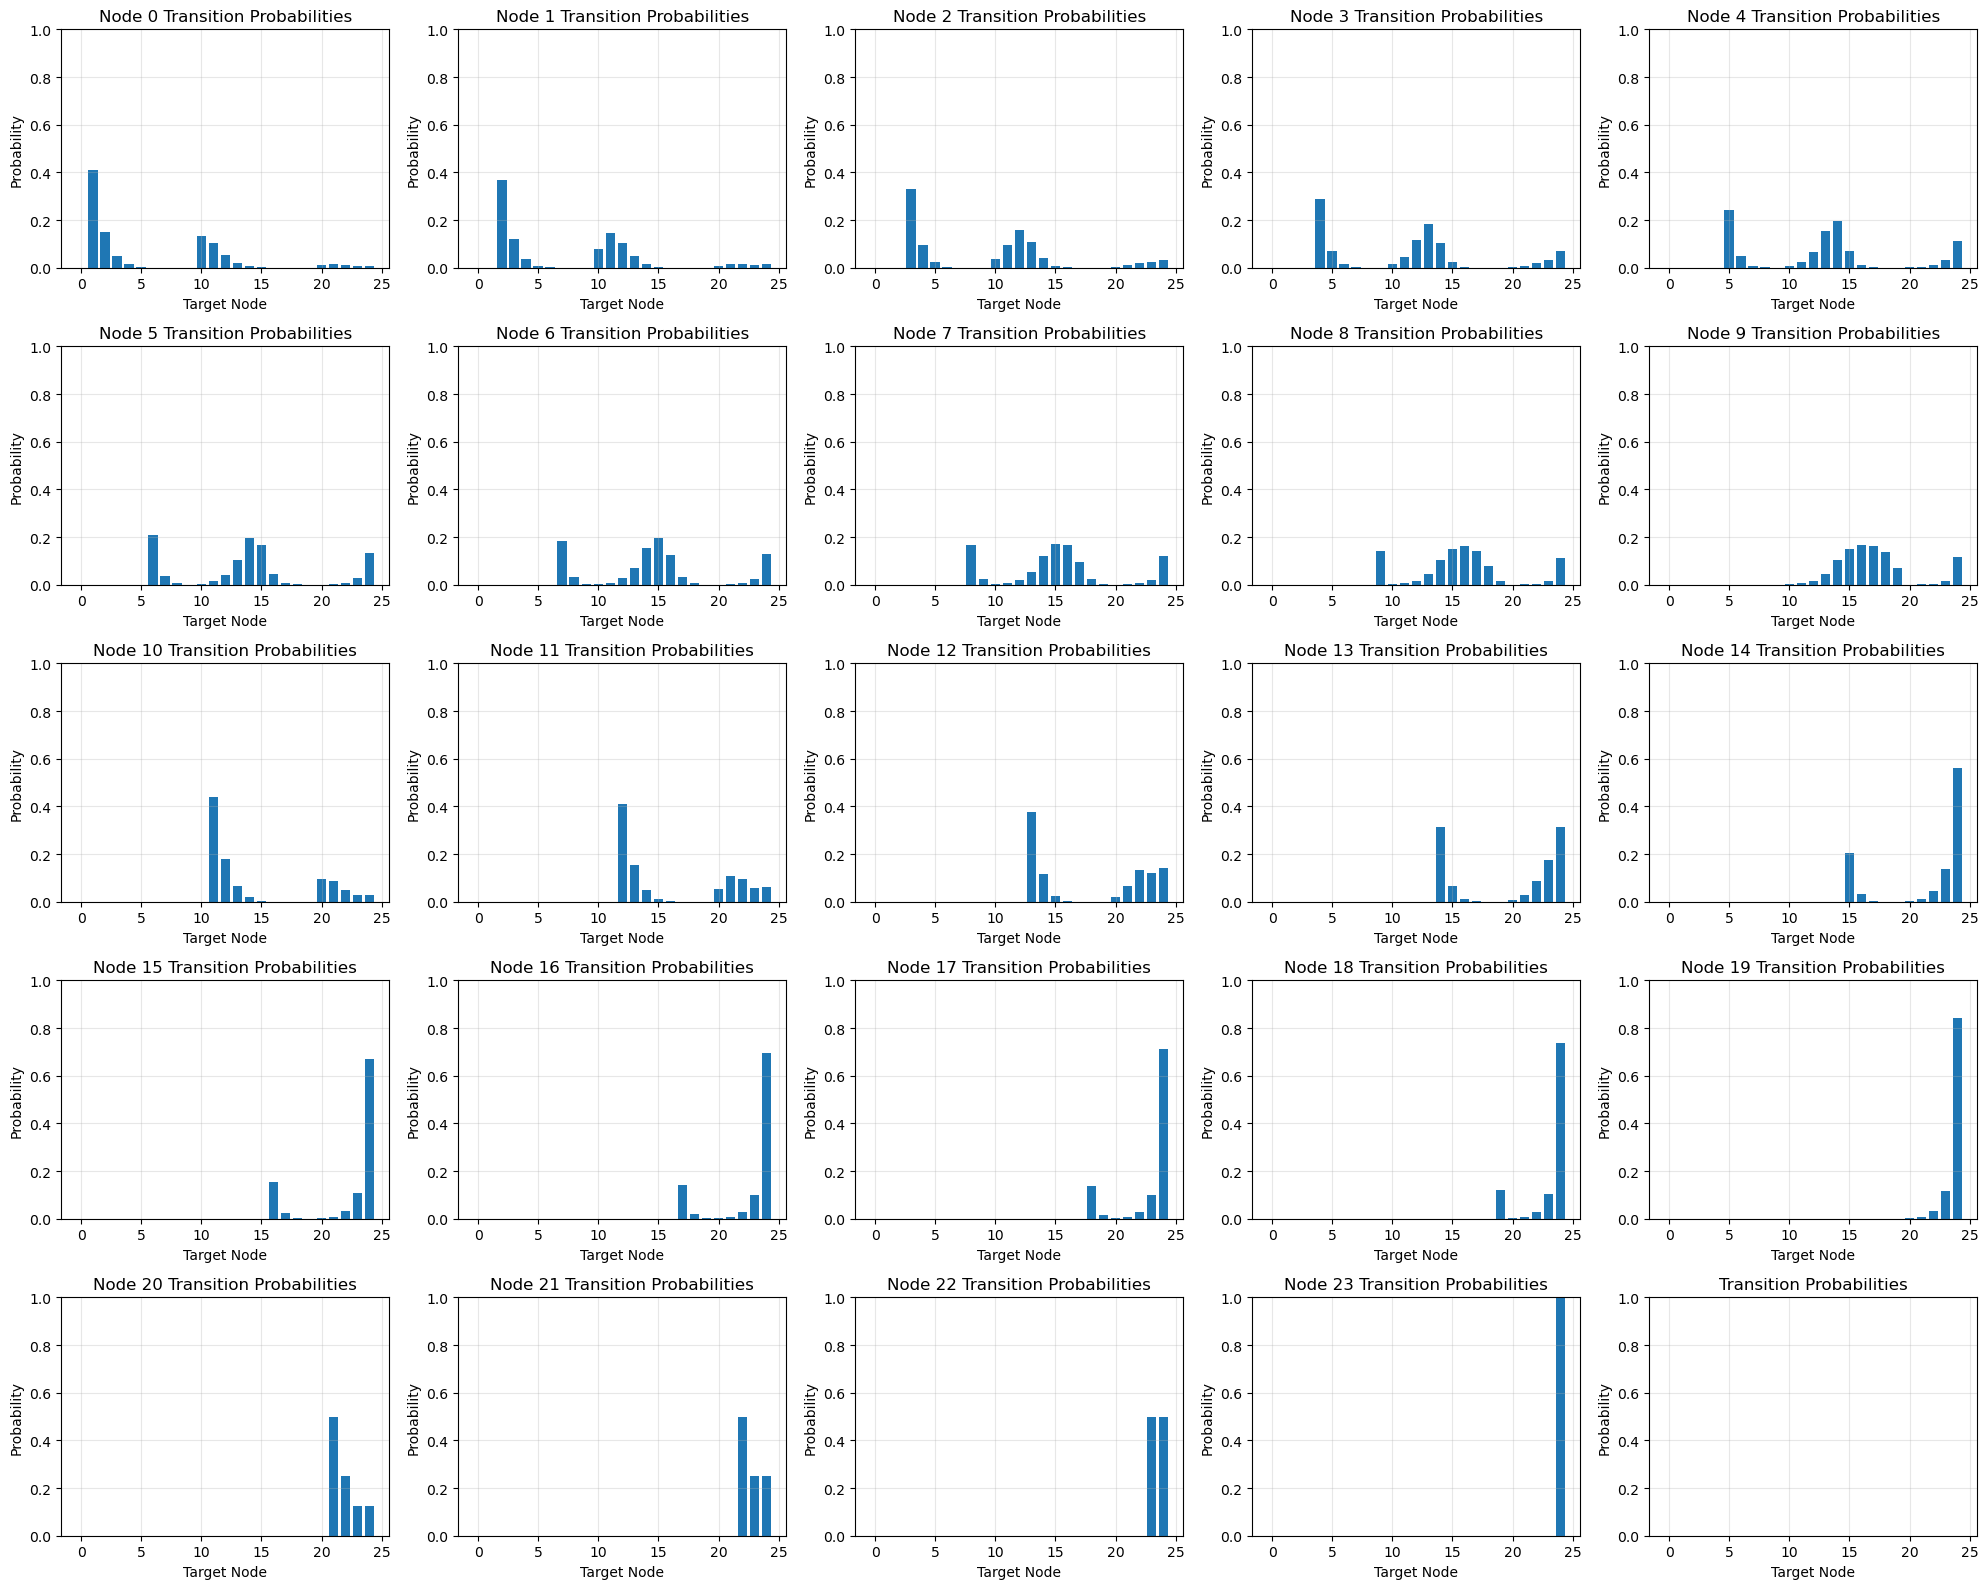

In [24]:
# Create a figure with 25 subplots (5x5 grid) to visualize transition probabilities
# for nodes 0 to 24
print('There probabilities always sum to 1 for each source node!')
fig, axes = plt.subplots(5, 5, figsize=(20, 16))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Get the dense array representation of Pe_csr
Pe_array = Pe_csr.toarray()

# For each node from 0 to 24, plot the outgoing transition probabilities
for i in range(25):
    ax = axes[i]
    
    # Extract outgoing transition probabilities for node i
    probs = Pe_array[i, :]
    
    # Only plot non-zero probabilities for clarity
    # non_zero_indices = np.where(probs > 0)[0]
    # non_zero_probs = probs[non_zero_indices]
    
    # # Create the bar chart
    # ax.bar(non_zero_indices, non_zero_probs)
    ax.bar(range(25), probs[:25])
    
    # Set title and labels
    ax.set_title(f'Node {i} Transition Probabilities')
    ax.set_xlabel('Target Node')
    ax.set_ylabel('Probability')
    
    # Set y-axis limit to [0, 1] since these are probabilities
    ax.set_ylim(0, 1)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)

plt.title('Transition Probabilities')
plt.tight_layout()
plt.show()


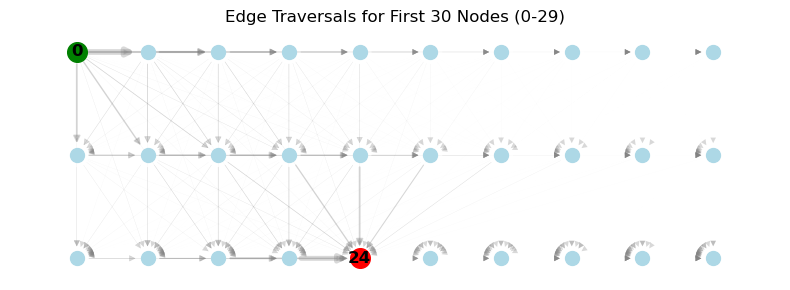

In [25]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Extract the edge traversals data
edge_traversals_array = edge_traversals.toarray()

# Create a new graph for visualization
G_vis = nx.DiGraph()

# Add only the first 30 nodes with positions based on grid layout
for i in range(30):
    row, col = i // 10, i % 10
    G_vis.add_node(str(i), pos=(col, 9-row))  # Adjust row to flip y-axis for better visualization

# Add edges with weights from edge_traversals (only for the first 30 nodes)
for i in range(30):
    for j in range(30):
        if edge_traversals_array[i, j] > 0:
            G_vis.add_edge(str(i), str(j), weight=edge_traversals_array[i, j])

# Get positions for all nodes
pos = nx.get_node_attributes(G_vis, 'pos')

# Create figure
plt.figure(figsize=(8, 3))

# Extract the path from node 0 to node 24
path_edges = []
current_node = '0'
target_node = '24'

# Find path with highest traversal weights
while current_node != target_node:
    neighbors = list(G_vis.neighbors(current_node))
    if not neighbors:
        break
    
    # Find neighbor with highest traversal weight
    next_node = max(neighbors, key=lambda n: G_vis[current_node][n]['weight'])
    path_edges.append((current_node, next_node))
    current_node = next_node

# Draw all nodes
nx.draw_networkx_nodes(G_vis, pos, node_size=100, node_color='lightblue')

# Draw all edges with varying width based on traversal weight
edges = G_vis.edges()
weights = [G_vis[u][v]['weight'] * 10 for u, v in edges]  # Scale for better visualization
nx.draw_networkx_edges(G_vis, pos, edgelist=edges, width=weights, alpha=0.3, edge_color='gray')

# Highlight start and end nodes
nx.draw_networkx_nodes(G_vis, pos, nodelist=['0'], node_size=200, node_color='green')
nx.draw_networkx_nodes(G_vis, pos, nodelist=['24'], node_size=200, node_color='red')

# Add labels for start and end nodes
nx.draw_networkx_labels(G_vis, pos, labels={'0': '0', '24': '24'}, font_weight='bold')

plt.title('Edge Traversals for First 30 Nodes (0-29)')
plt.axis('off')
plt.tight_layout()
plt.show()


# Boltzmann Sampling

In [64]:
from boltzmann import compute_boltzmann_partition_functions, sample_boltzmann_path
# Create a sample graph
# G = nx.DiGraph()
# G.add_edge('S', 'A', cost=1.0)
# G.add_edge('S', 'B', cost=4.0)
# G.add_edge('A', 'C', cost=1.0)
# G.add_edge('A', 'D', cost=1.0)
# G.add_edge('B', 'D', cost=1.0)
# G.add_edge('C', 'G', cost=1.0)
# G.add_edge('D', 'G', cost=5.0)
# # Add a cycle and alternative path
# G.add_edge('D', 'A', cost=0.5) # Cycle A->D->A
# G.add_edge('B', 'G', cost=1.0) # Faster path from B

start = '0'
goal = '24'
paths = []

# 1. Compute Z values
z_vals = compute_boltzmann_partition_functions(G, goal, max_iterations=200)
print("Computed Z values:", z_vals)

from tqdm import tqdm

# Check if start node has non-zero Z value
if z_vals.get(start, 0) == 0:
    print(f"Goal {goal} is not reachable from Start {start}")
else:
    # 2. Sample paths
    for i in tqdm(range(100_000), desc="Sampling paths"):
        path = sample_boltzmann_path(G, start, goal, z_vals)
        if path:
            cost = sum(G.edges[u, v]['weight'] for u, v in zip(path[:-1], path[1:]))
            # print(f"Sample {i+1}: Path={path}, Cost={cost:.2f}, Exp(-Cost)={math.exp(-cost):.4f}")
            paths.append(path)
        else:
            print(f"Sample {i+1}: Failed to generate path.")

Computed Z values: {'0': 495.22827253959156, '1': 362.0408770218369, '2': 264.6730889616195, '3': 193.49153221789436, '4': 141.45364452015562, '5': 103.41090030493898, '6': 75.59942579177782, '7': 55.26760876458164, '8': 40.40385950771425, '9': 29.53758810287599, '10': 21.593707174647058, '11': 15.786264874450017, '12': 11.540684360992202, '13': 8.436916305364486, '14': 6.167880042220073, '15': 4.50908161682578, '16': 3.2964027977233394, '17': 2.409863543895596, '18': 1.7617514170925808, '19': 1.287943486879099, '20': 0.9415621348736065, '21': 0.6883370760125317, '22': 0.503214724408055, '23': 0.36787944117144233, '24': 1.0, '25': 0.0, '26': 0.0, '27': 0.0, '28': 0.0, '29': 0.0, '30': 0.0, '31': 0.0, '32': 0.0, '33': 0.0, '34': 0.0, '35': 0.0, '36': 0.0, '37': 0.0, '38': 0.0, '39': 0.0, '40': 0.0, '41': 0.0, '42': 0.0, '43': 0.0, '44': 0.0, '45': 0.0, '46': 0.0, '47': 0.0, '48': 0.0, '49': 0.0, '50': 0.0, '51': 0.0, '52': 0.0, '53': 0.0, '54': 0.0, '55': 0.0, '56': 0.0, '57': 0.0, '58'

Sampling paths: 100%|██████████| 100000/100000 [00:12<00:00, 8112.89it/s]


In [65]:
from collections import Counter

def count_link_probabilities(paths):
    # Extract edges from all paths and count occurrences
    edge_counter = Counter()
    
    for path in paths:
        # Create pairs of consecutive nodes (edges)
        edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        # Use a set to ensure each edge is counted only once per path
        unique_edges = set(edges)
        for edge in unique_edges:
            edge_counter[edge] += 1
    
    return dict(edge_counter)

empirical_link_counts = count_link_probabilities(paths)
empirical_number_of_paths = len(paths)

# Print the top 10 edges by probability
sorted_edges = sorted(empirical_link_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("\033[92mMarginal probabilities of links (i, j) in the sampled paths\033[0m")
for edge, count in sorted_edges:
    print(f"{edge}: {count}")
print(f'Number of paths: {empirical_number_of_paths}')


Marginal probabilities of links (i, j) in the sampled paths
('23', '24'): 27040
('0', '1'): 26889
('0', '2'): 19706
('22', '24'): 19560
('21', '24'): 14332
('0', '3'): 14324
('0', '4'): 10483
('20', '24'): 10413
('0', '5'): 7669
('19', '24'): 7624
Number of paths: 100000


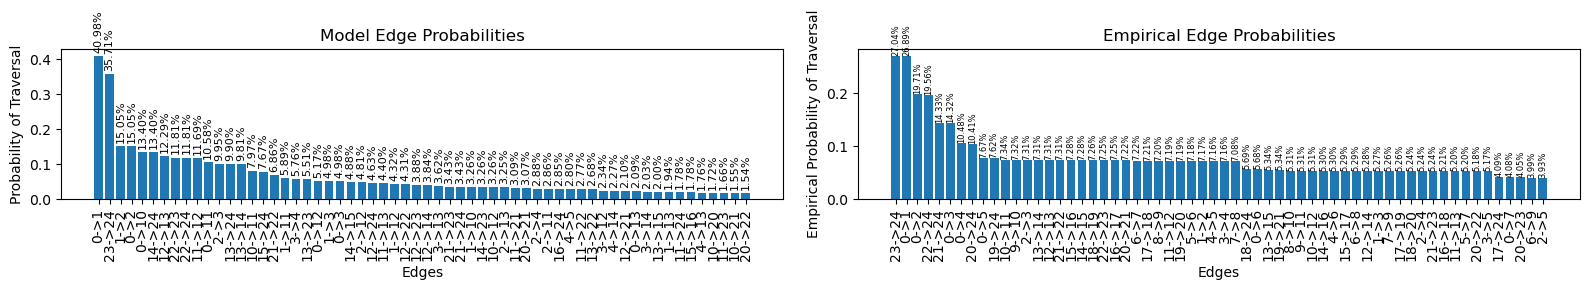

In [66]:
# Convert the Pe matrix to a list of (from_node, to_node, probability) tuples
# ================================ EXPECTED EDGE TRAVERSALS ================================
edge_probs = []
for i in range(edge_traversals_array.shape[0]):  # from node (row)
    for j in range(edge_traversals_array.shape[1]):  # to node (column)
        if edge_traversals_array[i, j] > 0:  # Only include edges with non-zero probability
            edge_probs.append((i, j, edge_traversals_array[i, j]))

# Sort by probability in descending order
sorted_edges = sorted(edge_probs, key=lambda x: x[2], reverse=True)

top_edges = sorted_edges

# Create a histogram of edge probabilities
plt.figure(figsize=(16, 3))
# 
plt.subplot(1, 2, 1)
# Extract edge labels and probabilities
edge_labels = [f"{edge[0]}->{edge[1]}" for edge in top_edges]
probabilities = [prob for _, _, prob in top_edges]
edge_labels = edge_labels[:60]
probabilities = probabilities[:60]

# Plot the histogram
plt.bar(range(len(probabilities)), probabilities)
plt.xlabel('Edges')
plt.ylabel('Probability of Traversal')
plt.title('Model Edge Probabilities')
plt.xticks(range(len(probabilities)), edge_labels, rotation=90)
plt.tight_layout()

# Add probability values on top of each bar
for i, prob in enumerate(probabilities):
    plt.text(i, prob + 0.01, f"{prob:.2%}", ha='center', fontsize=8, rotation=90, va='bottom')

# ================================ EMPIRICAL EDGE TRAVERSALS ================================
plt.subplot(1, 2, 2)

# Convert empirical_link_counts to a list of tuples (edge, count)
empirical_edges = [(edge, count) for edge, count in empirical_link_counts.items()]

# Sort by count in descending order
sorted_empirical_edges = sorted(empirical_edges, key=lambda x: x[1], reverse=True)

# Extract edge labels and counts
empirical_edge_labels = [f"{edge[0]}->{edge[1]}" for edge, _ in sorted_empirical_edges]
empirical_counts = [count for _, count in sorted_empirical_edges]

# Calculate probabilities (normalize counts)
empirical_probabilities = [count / empirical_number_of_paths for count in empirical_counts]
empirical_probabilities = empirical_probabilities[:60]
empirical_edge_labels = empirical_edge_labels[:60]

# Plot the histogram
plt.bar(range(len(empirical_probabilities)), empirical_probabilities)
plt.xlabel('Edges')
plt.ylabel('Empirical Probability of Traversal')
plt.title('Empirical Edge Probabilities')
plt.xticks(range(len(empirical_probabilities)), empirical_edge_labels, rotation=90)

# Add probability values on top of each bar
for i, prob in enumerate(empirical_probabilities):
    plt.text(i, prob + 0.001, f"{prob:.2%}", ha='center', fontsize=6, rotation=90, va='bottom')

plt.tight_layout()

plt.show()

In [67]:
# Compare empirical edge probabilities with model predictions
print("Comparing empirical edge probabilities with model predictions:")
print("=" * 80)
print(f"{'Edge':<15} {'Empirical':<15} {'Model':<15} {'Difference':<15}")
print("-" * 80)

# For each of the top 60 empirical edges, find the corresponding model probability
for i, edge_label in enumerate(empirical_edge_labels):
    # Parse the edge from the label (format: "source->target")
    source, target = map(int, edge_label.split('->'))
    edge = (source, target)
    
    # Get the empirical probability
    empirical_prob = empirical_probabilities[i]
    
    # Get the model probability (default to 0 if not found)
    model_prob = edge_traversals_array[edge]
    
    # Calculate the difference
    difference = empirical_prob - model_prob
    
    # Print the comparison
    print(f"{edge_label:<15} {empirical_prob:.6f}    {model_prob:.6f}    {difference:.6f}")

print("=" * 80)


Comparing empirical edge probabilities with model predictions:
Edge            Empirical       Model           Difference     
--------------------------------------------------------------------------------
23->24          0.270400    0.357090    -0.086690
0->1            0.268890    0.409755    -0.140865
0->2            0.197060    0.150454    0.046606
22->24          0.195600    0.118058    0.077542
21->24          0.143320    0.034308    0.109012
0->3            0.143240    0.049766    0.093474
0->4            0.104830    0.014394    0.090436
20->24          0.104130    0.007684    0.096446
0->5            0.076690    0.003498    0.073192
19->24          0.076240    0.000865    0.075375
10->11          0.073370    0.079714    -0.006344
9->10           0.073230    0.000001    0.073229
2->3            0.073120    0.099532    -0.026412
13->14          0.073100    0.098125    -0.025025
12->13          0.073100    0.122882    -0.049782
21->22          0.073050    0.068616    0.004434
15

## KL Divergence

In [ ]:
# TO BE REVISED

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

# First, count the occurrences of each edge in the sampled routes
# (This assumes 'sampled_routes' is already defined)
edge_counts = {}
total_edges = 0

for route in paths:
    for i in range(len(route) - 1):
        edge = (route[i], route[i+1])
        if edge in edge_counts:
            edge_counts[edge] += 1
        else:
            edge_counts[edge] = 1
        total_edges += 1

# Calculate probability of traversal for each edge
edge_probabilities = {edge: count / total_edges for edge, count in edge_counts.items()}

# Now compute KL divergence between Pe (model) and empirical edge distribution
# Pe is a sparse matrix where Pe[i,j] is the probability of traversing edge i->j

# Convert Pe to a dictionary format for easier comparison
Pe_dict = {}
rows, cols = Pe.nonzero()
for i, j in zip(rows, cols):
    Pe_dict[(i, j)] = Pe[i, j]

# Compute KL divergence: KL(P || Q) = sum(P(x) * log(P(x) / Q(x)))
kl_divergence = 0.0
for edge, emp_prob in edge_probabilities.items():
    # Get the model probability for this edge
    model_prob = Pe_dict.get(edge, 1e-10)  # Use a small value if edge not in model
    
    # Skip if model probability is 0 (this shouldn't happen for edges in the sample)
    if model_prob <= 0:
        continue
        
    # Add to KL divergence
    kl_divergence += emp_prob * np.log(emp_prob / model_prob)

print(f"KL divergence between sampled edge distribution and model: {kl_divergence:.4f}")

# We can also compute the reverse KL: KL(Q || P)
reverse_kl = 0.0
for edge, model_prob in Pe_dict.items():
    # Skip zero probabilities
    if model_prob <= 0:
        continue
        
    # Get empirical probability for this edge
    emp_prob = edge_probabilities.get(edge, 1e-10)  # Use a small value if edge not in sample
    
    # Add to reverse KL
    reverse_kl += model_prob * np.log(model_prob / emp_prob)

print(f"Reverse KL divergence (model to sample): {reverse_kl:.4f}")

# Optional: Plot the distributions for comparison
# Adjust the number of edges to show if there are too many
top_n = 20
sorted_edges = sorted(edge_probabilities.items(), key=lambda x: x[1], reverse=True)[:top_n]
sorted_edges_model = sorted(Pe_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]

plt.figure(figsize=(15, 6))

# Plot empirical probabilities
plt.subplot(1, 2, 1)
edges, probs = zip(*sorted_edges)
edge_labels = [f"{i}->{j}" for i, j in edges]
plt.bar(range(len(edge_labels)), probs)
plt.xticks(range(len(edge_labels)), edge_labels, rotation=90)
plt.title("Empirical Edge Probabilities")
plt.tight_layout()

# Plot model probabilities
plt.subplot(1, 2, 2)
edges, probs = zip(*sorted_edges_model)
edge_labels = [f"{i}->{j}" for i, j in edges]
plt.bar(range(len(edge_labels)), probs)
plt.xticks(range(len(edge_labels)), edge_labels, rotation=90)
plt.title("Model Edge Probabilities")
plt.tight_layout()

plt.show()

In [ ]:
# Sum all the probabilities of the edges in the paths
print(f'Empirical sum: {np.sum(np.array(list(edge_probabilities.values())))}')
# Sum all the probabilities of the edges in the Pe matrix
print(f'Model sum: {np.sum(Pe)}')

In [46]:
GX = G.copy() 
from dotenv import load_dotenv
load_dotenv

import os
PROJECT_ROOT = os.getenv('PROJECT_ROOT')
if PROJECT_ROOT:
    import sys
    sys.path.append(PROJECT_ROOT)


In [ ]:
# Sample 1000 routes from the optimized graph 

import lateral.planner_pivot_with_heuristics_lean_fix1100 as mcmc
MAX_ITER = 20_000
BURN_IN = 5_000 # can go as high as 10_000
THINNING = 50 # can go as high as 50 
sampled_routes = []
temperature = 1.0

total_accepted = 0

# Find the shortest path between 0 and 24
# shortest_path = nx.shortest_path(G, source='0', target='24', weight='weight')
shortest_path = ['0', '1', '24']
print(f'Shortest path: {shortest_path}')
route = shortest_path 

import time 
start_time = time.time()
for i in range(MAX_ITER):
    new_route, accepted = mcmc.mcmc_step(GX, route, temperature = 10.0, verbose = False,
                                    max_depth=8, collapse_pivot=False)
    
    print(f'{i < BURN_IN and "Burn-in" or "Sampling"} | Iteration {i+1}, accepted: {total_accepted}               ', end='\r')
    
    if accepted:
        route = new_route
        
    if i > BURN_IN: # Sampling phase
        if accepted:
            total_accepted += 1
        if i % THINNING == 0:
            sampled_routes.append(route)
        
print(f"Total chain time: {time.time() - start_time:.2f} seconds. Total accepted: {total_accepted}/{MAX_ITER - BURN_IN}")


In [ ]:
# Count the occurrences of each unique edge in the sampled routes
edge_counts = {}
total_edges = 0

for route in sampled_routes:
    for i in range(len(route) - 1):
        edge = (route[i], route[i+1])
        if edge in edge_counts:
            edge_counts[edge] += 1
        else:
            edge_counts[edge] = 1
        total_edges += 1

# Calculate probability of traversal for each edge
edge_probabilities = {edge: count / total_edges for edge, count in edge_counts.items()}

# Sort the edges by probability in descending order
sorted_edges = sorted(edge_probabilities.items(), key=lambda x: x[1], reverse=True)

# Create a histogram of edge probabilities
plt.figure(figsize=(12, 8))

# Extract edge labels and probabilities
edge_labels = [f"{edge[0]}->{edge[1]}" for edge, _ in sorted_edges]
probabilities = [prob for _, prob in sorted_edges]

# Plot the histogram
plt.bar(edge_labels, probabilities)
plt.xlabel('Edges')
plt.ylabel('Probability of Traversal')
plt.title('Probability of Edge Traversal in Sampled Routes')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated labels

# Add probability values on top of each bar (formatted as percentages)
for i, prob in enumerate(probabilities):
    plt.text(i, prob + 0.01, f"{prob:.1%}", ha='center', rotation=90, va='bottom')

plt.show()


In [ ]:
# Convert the edge_traversals_array to a list of (i, j, probability) tuples
edge_probs = []
for i in range(edge_traversals_array.shape[0]):
    for j in range(edge_traversals_array.shape[1]):
        if edge_traversals_array[i, j] > 0:  # Only include edges with non-zero probability
            edge_probs.append((i, j, edge_traversals_array[i, j]))

# Sort by probability in descending order
sorted_edges = sorted(edge_probs, key=lambda x: x[2], reverse=True)

# Take top 50 edges for better visualization
top_edges = sorted_edges[:50]

# Create a histogram of edge probabilities
plt.figure(figsize=(10, 10))

# Extract edge labels and probabilities
edge_labels = [f"{edge[0]}->{edge[1]}" for edge in top_edges]
probabilities = [prob for _, _, prob in top_edges]

# Plot the histogram
plt.bar(range(len(probabilities)), probabilities)
plt.xlabel('Edges')
plt.ylabel('Probability of Traversal')
plt.title('Top 50 Most Frequently Traversed Edges')
plt.xticks(range(len(probabilities)), edge_labels, rotation=90)
plt.tight_layout()

# Add probability values on top of each bar
for i, prob in enumerate(probabilities):
    plt.text(i, prob + 0.01, f"{prob:.2%}", ha='center', fontsize=8, rotation=90, va='bottom')

plt.show()